In [ ]:
select
	l_returnflag,
	l_linestatus,
	sum(l_quantity) as sum_qty,
	sum(l_extendedprice) as sum_base_price,
	sum(l_extendedprice * (1 - l_discount)) as sum_disc_price,
	sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge,
	avg(l_quantity) as avg_qty,
	avg(l_extendedprice) as avg_price,
	avg(l_discount) as avg_disc,
	count(*) as count_order
from
	lineitem
where
	l_shipdate <= date '1998-12-01' - interval ':1' day (3)
group by
	l_returnflag,
	l_linestatus
order by
	l_returnflag,
	l_linestatus

In [138]:
X = [1, 2, 3, 4, 5]

kde_ = gaussian_kde(X, bw_method='silverman', weights = [2, 2, 3, 4, 5])
X_plot = np.linspace(0, 10, 100)
# plt.plot(X_plot, kde_.evaluate(X_plot))

integrate.quad(lambda x: kde_.evaluate([[x]]), 0, 6)


# with open('./pickles/kde_.pkl', 'wb') as file:
#     hashMap_kde = pickle.dump(kde_, file)

# kde_.integrate_box_1d(1, 2) * np.sum(X)

(0.8871648751208667, 1.6521956912450115e-10)

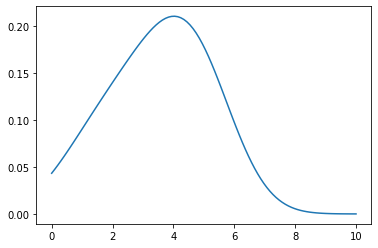

In [139]:
X_plot = np.linspace(0, 10, 100)
plt.plot(X_plot, kde_.evaluate(X_plot))

In [280]:
from scipy.stats import gaussian_kde

X = [[1, 1, 1, 2, 2], [1, 2, 3, 1, 2]]

kde_ = gaussian_kde(X, bw_method=.1, weights = [1, 1, 1, 10, 10])
# X_plot = np.linspace(0, 6, 100)

# plt.plot(X_plot, kde_.evaluate(X_plot))
X_values = X[0]
Y_values = X[1]

kde_.evaluate([[1], [2]])

array([2.29520421])

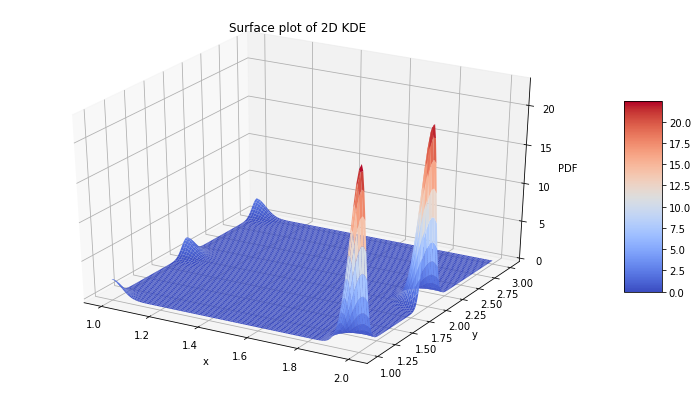

In [281]:
from mpl_toolkits.mplot3d import Axes3D
x = np.linspace(min(X_values), max(X_values), 100)
y = np.linspace(min(Y_values), max(Y_values), 100)
xx, yy = np.meshgrid(x, y)
z = kde_.evaluate([np.ravel(xx), np.ravel(yy)])
zz = z.reshape(xx.shape) #np.exp(z).reshape(xx.shape)

# Plot the 3D prob density distribution
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF

In [95]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from collections import Counter
from sklearn.model_selection import GridSearchCV
import scipy
from scipy import integrate
import timeit
import pickle
from datetime import date, timedelta
import sys
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.functions import col
import numpy as np 
import pandas as pd
from pyspark import broadcast
# To avoid OverflowError: cannot serialize a string larger than 4GiB
def broadcast_dump(self, value, f):
    pickle.dump(value, f, 4)  # was 2, 4 is first protocol supporting >4GB
    f.close()
    return f.name
broadcast.Broadcast.dump = broadcast_dump

conf = pyspark.SparkConf().setMaster("local[16]").setAll([
                                   ('spark.executor.memory', '4g'),  # find
                                   ('spark.driver.memory','10g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Read in Data

In [4]:
lineitem = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/lineitem.parquet")

#### Helper Functions

In [5]:
def calculate_error(Q1_approx, Q1_exact):
    df_2 = Q1_approx.toPandas().set_index(['l_returnflag', 'l_linestatus']).astype(float)
    df_1 = Q1_exact.toPandas().set_index(['l_returnflag', 'l_linestatus']).astype(float)
    return abs(df_2 - df_1) * 100 / df_1

In [6]:
def calculate_size_of(obj):
    p = pickle.dumps(obj)
    size = sys.getsizeof(p)
    print('The size of the object in MB: ', size / 2 ** 20)
    return size

#### -> Exact Solution

In [7]:
def compute_exact_result(lineitem, left_date, right_date):
    return lineitem.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
            .groupby("l_returnflag", "l_linestatus")\
            .agg(f.sum('l_quantity').alias('sum_qty'), f.sum('l_extendedprice').alias('sum_base_price'), \
                 f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('sum_disc_price'),\
                 f.sum(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('sum_charge'),\
                 f.avg("l_quantity").alias('avg_qty'), f.avg('l_extendedprice').alias('avg_price'), \
                 f.avg('l_discount').alias('avg_disc'), f.count('*').alias('count_order') )\
            .sort("l_returnflag", "l_linestatus").cache()

In [9]:
LEFT_DATE = date(1998, 12, 1) - timedelta(days = 2000)
RIGHT_DATE = date(1998, 12, 1) + timedelta(days = 2000)

In [10]:
Q1_exact = compute_exact_result(lineitem, LEFT_DATE, RIGHT_DATE)
Q1_exact.show()

+------------+------------+-----------+---------------+-----------------+-------------------+---------+------------+--------+-----------+
|l_returnflag|l_linestatus|    sum_qty| sum_base_price|   sum_disc_price|         sum_charge|  avg_qty|   avg_price|avg_disc|count_order|
+------------+------------+-----------+---------------+-----------------+-------------------+---------+------------+--------+-----------+
|           A|           F|23005607.00| 34499473679.55| 32777046191.3228| 34088236497.836855|25.526446|38279.752342|0.049941|     901246|
|           N|           F|  991417.00|  1487504710.38|  1413082168.0541|  1469649223.194375|25.516472|38284.467761|0.050093|      38854|
|           N|           O|76633518.00|114935210409.19|109189591897.4720|113561024263.013782|25.502020|38248.015609|0.050000|    3004998|
|           R|           F|23010024.00| 34508501347.22| 32785009167.3502| 34095304826.338860|25.499545|38242.075143|0.049994|     902370|
+------------+------------+-------

# Weighted KDE based

In [11]:
lineitem_clean = lineitem.withColumn('l_shipdate', f.to_date('l_shipdate', 'yyyy-MM-dd'))
lineitem_schema = dict(zip(lineitem_clean.schema.names, range(len(lineitem_clean.schema.names))))

for col_name in lineitem.schema.names[:8]:
    lineitem_clean = lineitem_clean.withColumn(col_name, col(col_name).cast('float'))

In [12]:
transform, i_transform = {}, {}
normalize = {}

START_DATE = lineitem_clean.select(f.min('l_shipdate')).first()[0]
END_DATE = lineitem_clean.select(f.max('l_shipdate')).first()[0]
normalize['date'] = (START_DATE, END_DATE)
def lambda_normalize_date(x):
    transformed_date = -1 + 2 * (x - normalize['date'][0]).days / (normalize['date'][1] - normalize['date'][0]).days
    if transformed_date < -1: return -1
    elif transformed_date > 1: return 1
    else: return transformed_date
transform['date'] = lambda_normalize_date

In [13]:
def compute_kdes(s_values, bw='scott'):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    kdes_bank = dict()
    
    # Training Data
    X_shipdate = []
    X_quantity = []
    X_price = []
    X_disc = []
    X_price_disc = []
    X_price_disc_tax = []
    X_count = []
    
    # Fill in the training data
    for row in iterable_rows:
        X_shipdate.append(transform['date'](row['l_shipdate']))
        X_quantity.append(row['sum_qty'])
        X_price.append(row['sum_base_price'])
        X_disc.append(row['sum_disc'])
        X_price_disc.append(row['sum_disc_price'])
        X_price_disc_tax.append(row['sum_charge'])
        X_count.append(row['count_order'])
        
    # Store the trained model into the KDE bank
    kdes_bank['quantity'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_quantity)
    kdes_bank['quantity_sum'] = np.sum(X_quantity)
    kdes_bank['price'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_price)
    kdes_bank['price_sum'] = np.sum(X_price)
    kdes_bank['disc'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_disc)
    kdes_bank['disc_sum'] = np.sum(X_disc)
    kdes_bank['disc_price'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_price_disc)
    kdes_bank['disc_price_sum'] = np.sum(X_price_disc)
    kdes_bank['charge'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_price_disc_tax)
    kdes_bank['charge_sum'] = np.sum(X_price_disc_tax)
    kdes_bank['count'] = gaussian_kde(X_shipdate, bw_method=bw, weights = X_count)
    kdes_bank['count_sum'] = np.sum(X_count)
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, kdes_bank]

In [14]:
def kde_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.groupby('l_returnflag', 'l_linestatus', 'l_shipdate')\
            .agg(f.sum('l_quantity').alias('sum_qty'), f.sum('l_extendedprice').alias('sum_base_price'), \
                 f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('sum_disc_price'),\
                 f.sum(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('sum_charge'),\
                 f.sum('l_discount').alias('sum_disc'), f.count('*').alias('count_order') ).rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus']]), row)).groupByKey()\
        .map(compute_kdes)
    # (RDD) strat_kde: flag, status, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    # The last two items are: stratum_str(-2), kdes_bank(-1)
    
    strata_catalogue = strat_kde.map(lambda row: row[:3]).toDF(["l_returnflag", "l_linestatus", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

In [15]:
strata_catalogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
strata_catalogue = strata_catalogue.cache()
strata_catalogue.show()

+------------+------------+-----------+
|l_returnflag|l_linestatus|stratum_str|
+------------+------------+-----------+
|           R|           F|        R_F|
|           N|           F|        N_F|
|           N|           O|        N_O|
|           A|           F|        A_F|
+------------+------------+-----------+



In [26]:
kde = hashMap_kde['N_O']['quantity']
kde.set_bandwidth(.1)
plt.plot(np.linspace(-1, 1, 10000), kde.evaluate(np.linspace(-1, 1, 10000)))

AttributeError: 'NoneType' object has no attribute 'evaluate'

## Testing

In [30]:
def kde_based_cal_result(row, l_date, r_date, bw):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    x_left, x_right = transform['date'](l_date), transform['date'](r_date)
    kde_bank = hashMap_kde[row['stratum_str']]
    
    kde_count = kde_bank['count']; kde_count.set_bandwidth(bw)
    count_order = kde_bank['count_sum'] * kde_count.integrate_box_1d(x_left, x_right)
    
    kde_quantity = kde_bank['quantity']; kde_quantity.set_bandwidth(bw)
    sum_qty = kde_bank['quantity_sum'] * kde_quantity.integrate_box_1d(x_left, x_right)
    avg_qty = sum_qty / count_order
    
    kde_price = kde_bank['price']; kde_price.set_bandwidth(bw)
    sum_base_price = kde_bank['price_sum'] * kde_price.integrate_box_1d(x_left, x_right)
    avg_price = sum_base_price / count_order
    
    kde_disc = kde_bank['disc']; kde_disc.set_bandwidth(bw)
    avg_disc = kde_bank['disc_sum'] * kde_disc.integrate_box_1d(x_left, x_right) / count_order
    
    kde_disc_price = kde_bank['disc_price']; kde_disc_price.set_bandwidth(bw)
    sum_disc_price = kde_bank['disc_price_sum'] * kde_disc_price.integrate_box_1d(x_left, x_right)
    
    kde_charge = kde_bank['charge']; kde_charge.set_bandwidth(bw)
    sum_charge = kde_bank['charge_sum'] * kde_charge.integrate_box_1d(x_left, x_right)
                           
    return (row['l_returnflag'], row['l_linestatus'], float(sum_qty), float(sum_base_price), float(sum_disc_price),\
            float(sum_charge), float(avg_qty), float(avg_price), float(avg_disc), float(count_order))

In [31]:
def kde_based_method_testing(strata_catalogue, l_date, r_date, bw):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    Q1_kde_approx = strata_catalogue.rdd.map(lambda x: kde_based_cal_result(x, l_date, r_date, bw))\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_kde_approx

In [32]:
Q1_kde_approx = kde_based_method_testing(strata_catalogue, LEFT_DATE, RIGHT_DATE, .1).cache()
# Q1_kde_approx.show()
calculate_error(Q1_kde_approx, Q1_exact).mean().mean()

0.061577356121153705

In [33]:
calculate_error(Q1_kde_approx, Q1_exact)

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                             
A            F             0.087081    8.617302e-02    8.642027e-02   
N            F             0.000000    1.695469e-08    1.081826e-07   
             O             0.218295    2.185770e-01    2.185527e-01   
R            F             0.085339    8.577988e-02    8.590821e-02   

                           sum_charge       avg_qty     avg_price  avg_disc  \
l_returnflag l_linestatus                                                     
A            F               0.086772  5.524821e-03  4.614828e-03  0.001059   
N            F               0.000001  3.114734e-07  1.655845e-08  0.000852   
             O               0.218542  2.287812e-04  5.099324e-04  0.000010   
R            F               0.085895  2.723588e-03  2.284199e-03  0.001639   

                           count_order  
l_returnflag l_linestatus               
A            F                0.081562  
N            F                0.000000  
             O                0.218068  
R            F                0.088062

## Discussion: Error vs Selectivity, Running time vs Seletivity, Space vs Selectivity. 
## Error vs bandwidth, runningtime vs bandwidth, Space vs bw. 

In [36]:
def impact_of_selectivity(x_plot):
    error_bank, runtime, space = [], [], []
    for d in x_plot:
        left_date = date(1998, 12, 1) - timedelta(days = int(d))
        right_date= date(1998, 12, 1) + timedelta(days = int(d))
        
        # Construction
        start = timeit.default_timer()
        strata_catalogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
        strata_catalogue = strata_catalogue.cache(); strata_catalogue.count()
        stop = timeit.default_timer(); construction_time = stop - start
        
        # Approximation
        start = timeit.default_timer()
        Q1_kde_approx = kde_based_method_testing(strata_catalogue, left_date, right_date, 'scott').cache(); Q1_kde_approx.count()
        stop = timeit.default_timer(); estimation_time = stop - start
        
        # Exact
        start = timeit.default_timer()
        Q1_exact = compute_exact_result(lineitem, left_date, right_date); Q1_exact.count()
        stop = timeit.default_timer(); exact_time = stop - start
        
        # Store performace
        runtime.append([construction_time, estimation_time, exact_time])
        space.append(calculate_size_of(hashMap_kde) + calculate_size_of(strata_catalogue.toPandas()))
        error_bank.append((calculate_error(Q1_kde_approx, Q1_exact).mean().mean(), calculate_error(Q1_kde_approx, Q1_exact).mean().std()))
    return error_bank, runtime, space

In [37]:
x_plot = np.linspace(100, 4000, 5)
error_bank, runtime, space = impact_of_selectivity(x_plot)

The size of the object in MB:  0.3635749816894531
The size of the object in MB:  0.0008783340454101562
The size of the object in MB:  0.3635749816894531
The size of the object in MB:  0.0008783340454101562
The size of the object in MB:  0.3635749816894531
The size of the object in MB:  0.0008783340454101562
The size of the object in MB:  0.3635749816894531
The size of the object in MB:  0.0008783340454101562
The size of the object in MB:  0.3635749816894531
The size of the object in MB:  0.0008783340454101562


<ErrorbarContainer object of 3 artists>

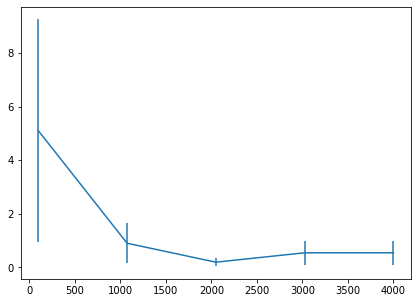

In [39]:
# Error
plt.figure(figsize=(7, 5))
plt.errorbar(x_plot, [mean for mean, std in error_bank], yerr=[std for mean, std in error_bank])

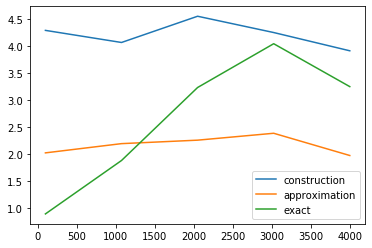

In [50]:
plt.figure(figsize=(6, 4))
plt.plot(x_plot, np.array(runtime)[:,0], label='construction')
plt.plot(x_plot, np.array(runtime)[:,1], label='approximation')
plt.plot(x_plot, np.array(runtime)[:,2], label='exact')
plt.legend()

Text(0.5, 1.0, 'error vs length of date predicate')

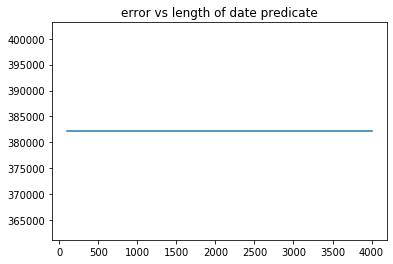

In [42]:
ax = plt.axes()
plt.plot(x_plot, space)
ax.set_title("error vs length of date predicate")

In [51]:
def impact_of_bandwidth(bw_plot):
    error_bank, runtime, space = [], [], []
    for bw in bw_plot:
        left_date = date(1998, 12, 1) - timedelta(days = 2000)
        right_date= date(1998, 12, 1) + timedelta(days = 2000)
        
        # Construction
        start = timeit.default_timer()
        strata_catalogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
        strata_catalogue = strata_catalogue.cache(); strata_catalogue.count()
        stop = timeit.default_timer(); construction_time = stop - start
        
        # Approximation
        start = timeit.default_timer()
        Q1_kde_approx = kde_based_method_testing(strata_catalogue, left_date, right_date, bw).cache(); Q1_kde_approx.count()
        stop = timeit.default_timer(); estimation_time = stop - start
        
        # Exact
        start = timeit.default_timer()
        Q1_exact = compute_exact_result(lineitem, left_date, right_date); Q1_exact.count()
        stop = timeit.default_timer(); exact_time = stop - start
        
        # Store performace
        runtime.append([construction_time, estimation_time, exact_time])
        space.append(calculate_size_of(hashMap_kde) + calculate_size_of(strata_catalogue.toPandas()))
        error_bank.append((calculate_error(Q1_kde_approx, Q1_exact).mean().mean(), calculate_error(Q1_kde_approx, Q1_exact).mean().std()))
    return error_bank, runtime, space

In [58]:
bw_plot = list(np.linspace(.05, 1, 5))
error_bank_bw, runtime_bw, space_bw = impact_of_bandwidth(bw_plot + ['scott', 'silverman'])

<ErrorbarContainer object of 3 artists>

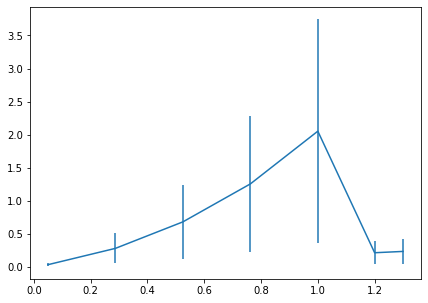

In [59]:
# Error
plt.figure(figsize=(7, 5))
plt.errorbar(bw_plot + [1.2, 1.3], [mean for mean, std in error_bank_bw], yerr=[std for mean, std in error_bank_bw])

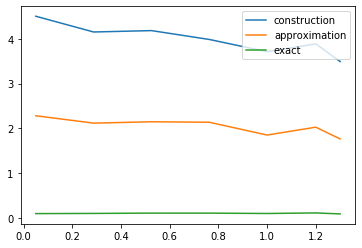

In [61]:
plt.figure(figsize=(6, 4))
plt.plot(bw_plot + [1.2, 1.3], np.array(runtime_bw)[:,0], label='construction')
plt.plot(bw_plot + [1.2, 1.3], np.array(runtime_bw)[:,1], label='approximation')
plt.plot(bw_plot + [1.2, 1.3], np.array(runtime_bw)[:,2], label='exact')
plt.legend()

Text(0.5, 1.0, 'error vs length of date predicate')

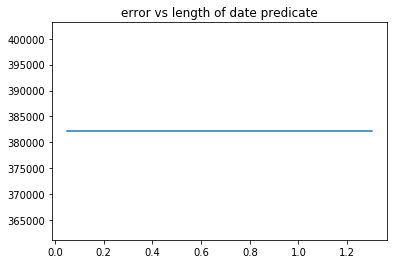

In [62]:
ax = plt.axes()
plt.plot(bw_plot + [1.2, 1.3], space_bw)
ax.set_title("error vs length of date predicate")

# 1. KDE-Based

## 1.0. Cleaning and Normalization

In [11]:
lineitem_clean = lineitem.withColumn('l_shipdate', f.to_date('l_shipdate', 'yyyy-MM-dd'))
lineitem_schema = dict(zip(lineitem_clean.schema.names, range(len(lineitem_clean.schema.names))))

for col_name in lineitem.schema.names[:8]:
    lineitem_clean = lineitem_clean.withColumn(col_name, col(col_name).cast('float'))

In [12]:
# transform = lambda x, avg, stddev: (x - avg)/stddev
# i_transform = lambda x, avg, stddev: x * stddev + avg
transform, i_transform = {}, {}
normalize = {}

START_DATE = lineitem_clean.select(f.min('l_shipdate')).first()[0]
END_DATE = lineitem_clean.select(f.max('l_shipdate')).first()[0]
normalize['date'] = (START_DATE, END_DATE)
def lambda_normalize_date(x):
    transformed_date = -1 + 2 * (x - normalize['date'][0]).days / (normalize['date'][1] - normalize['date'][0]).days
    if transformed_date < -1: return -1
    elif transformed_date > 1: return 1
    else: return transformed_date
transform['date'] = lambda_normalize_date

MIN_QUANTITY = lineitem_clean.select(f.min('l_quantity')).first()[0]
MAX_QUANTITY = lineitem_clean.select(f.max('l_quantity')).first()[0]
normalize['quantity'] = (MIN_QUANTITY, MAX_QUANTITY)
transform['quantity'] = lambda x: -1 + 2 * (x - normalize['quantity'][0])/(normalize['quantity'][1] - normalize['quantity'][0])
i_transform['quantity'] = lambda x: 0.5 * (x + 1) * (normalize['quantity'][1] - normalize['quantity'][0]) + normalize['quantity'][0]

avg = lineitem_clean.select(f.avg('l_extendedprice')).first()[0]
stddev = lineitem_clean.select(f.stddev('l_extendedprice')).first()[0]
normalize['price'] = (avg, stddev)
transform['price'] = lambda x: (x - normalize['price'][0])/normalize['price'][1]
i_transform['price'] = lambda x: x * normalize['price'][1] + normalize['price'][0]

avg = lineitem_clean.select(f.avg('l_discount')).first()[0]
stddev = lineitem_clean.select(f.stddev('l_discount')).first()[0]
normalize['disc'] = (avg, stddev)
transform['disc'] = lambda x: (x - normalize['disc'][0])/normalize['disc'][1]
i_transform['disc'] = lambda x: x * normalize['disc'][1] + normalize['disc'][0]

In [13]:
transform['price'](lineitem_clean.select(f.max('l_extendedprice')).first()[0])
transform['price'](lineitem_clean.select(f.max(f.col('l_extendedprice') * (1 - f.col('l_discount')))).first()[0])
transform['price'](lineitem_clean.select(f.max(f.col('l_extendedprice') * (1 - f.col('l_discount')) * (1 + f.col('l_tax')))).first()[0])

3.1289484625132213

In [14]:
transform['price'](lineitem_clean.select(f.min('l_extendedprice')).first()[0])
transform['price'](lineitem_clean.select(f.min(f.col('l_extendedprice') * (1 - f.col('l_discount')))).first()[0])
transform['price'](lineitem_clean.select(f.min(f.col('l_extendedprice') * (1 - f.col('l_discount')) * (1 + f.col('l_tax')))).first()[0])

-1.5737247639414813

In [17]:
transform['date'](lineitem_clean.select(f.max('l_shipdate')).first()[0])

1.0

## 1.1. KDE Construction

In [110]:
def compute_kdes(s_values, kn='gaussian', bw=.1):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    
    kdes_bank = dict()
    
    # Training Data
    X_quantity = [] # Each item in the array is a tuple of (shipdate, l_quantity)
    X_price = []
    X_disc = []
    X_price_disc = []
    X_price_disc_tax = []
    
    # Fill in the training data
    for row in iterable_rows:
        shipdate_delta = transform['date'](row['l_shipdate'])
        X_quantity.append([shipdate_delta, transform['quantity'](row['l_quantity'])])
        X_price.append([shipdate_delta,transform['price'](row['l_extendedprice'])])
        X_disc.append([shipdate_delta,transform['disc'](row['l_discount'])])
        X_price_disc.append([shipdate_delta, transform['price'](row['l_extendedprice'] * (1 - row['l_discount'])) ])
        X_price_disc_tax.append([shipdate_delta, transform['price'](row['l_extendedprice'] * (1 - row['l_discount']) * (1 + row['l_tax']))  ])
    
    # Store the trained model into the KDE bank
    kdes_bank['n'] = len(iterable_rows)
    kdes_bank['quantity'] = KernelDensity(kernel=kn, bandwidth=bw).fit(np.array(X_quantity))
    kdes_bank['price'] = KernelDensity(kernel=kn, bandwidth=bw).fit(np.array(X_price))
    kdes_bank['disc'] = KernelDensity(kernel=kn, bandwidth=bw).fit(np.array(X_disc))
    kdes_bank['disc_price'] = KernelDensity(kernel=kn, bandwidth=bw).fit(np.array(X_price_disc))
    kdes_bank['charge'] = KernelDensity(kernel=kn, bandwidth=bw).fit(np.array(X_price_disc_tax))
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, kdes_bank]

In [111]:
def kde_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus']]), row)).groupByKey()\
        .map(lambda str_rows: compute_kdes(str_rows) )
    # (RDD) strat_kde: flag, status, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    # The last two items are: stratum_str(-2), kdes_bank(-1)
    
    strata_catalogue = strat_kde.map(lambda row: row[:3]).toDF(["l_returnflag", "l_linestatus", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

In [112]:
strata_catalogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
strata_catalogue = strata_catalogue.cache()
strata_catalogue.show()

+------------+------------+-----------+
|l_returnflag|l_linestatus|stratum_str|
+------------+------------+-----------+
|           N|           O|        N_O|
|           R|           F|        R_F|
|           A|           F|        A_F|
|           N|           F|        N_F|
+------------+------------+-----------+



In [113]:
hashMap_kde['N_O']

{'n': 1024,
 'quantity': KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
               kernel='gaussian', leaf_size=40, metric='euclidean',
               metric_params=None, rtol=0),
 'price': KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
               kernel='gaussian', leaf_size=40, metric='euclidean',
               metric_params=None, rtol=0),
 'disc': KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
               kernel='gaussian', leaf_size=40, metric='euclidean',
               metric_params=None, rtol=0),
 'disc_price': KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
               kernel='gaussian', leaf_size=40, metric='euclidean',
               metric_params=None, rtol=0),
 'charge': KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
               kernel='gaussian', leaf_size=40, metric='euclidean',
               metric_params=None, rtol

In [46]:
file = open('./pickles/hashMap_kde.pkl', 'wb')
pickle.dump(hashMap_kde, file)
file.close()

#### Uptil now the construction phas is completed. To be stored are two main objects (hashMap_kde and strata_catalouge) and normalization paramters. 
All these is done in the big database in Spark.

---

#### As below is to compute the results with KDE locally with Pandas DF and KDE of sk-learn

In [20]:
with open('./pickles/hashMap_kde.pkl', 'rb') as file:
    hashMap_kde = pickle.load(file)

In [31]:
strata_catalogue = lineitem_clean.select('l_returnflag', 'l_linestatus').drop_duplicates().toPandas()
strata_catalogue['stratum_str'] = strata_catalogue.agg(lambda row: f"{row['l_returnflag']}_{row['l_linestatus']}", axis=1)
strata_catalogue

,l_returnflag,l_linestatus,stratum_str
0,N,O,N_O
1,R,F,R_F
2,A,F,A_F
3,N,F,N_F


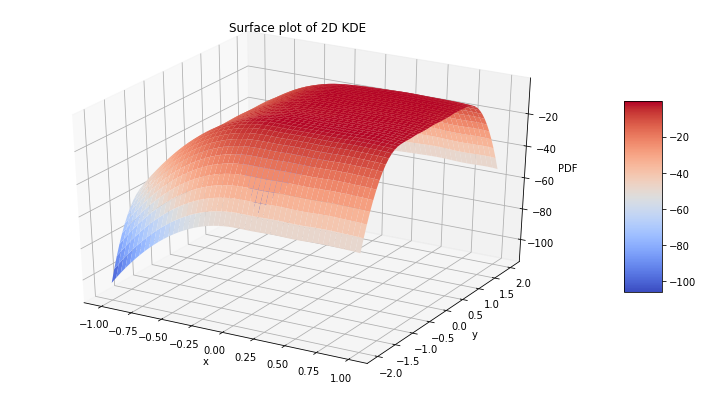

In [20]:
plot_2D_KDE(hashMap_kde['N_O']['quantity'], [-1, 1], [-2, 2], 50)

In [436]:
# Compute AVG_QUANTITY
kde = hashMap_kde['N_O']['quantity']
i1 = integrate.dblquad(lambda x, y: i_transform['quantity'](y) * np.exp(kde.score_samples([[x,y]])), -1, 1, transform['date'](left_date), transform['date'](right_date))
i2 = integrate.dblquad(lambda x, y: np.exp(kde.score_samples([[x,y]])), -1, 1, transform['date'](left_date), transform['date'](right_date))
i1[0] / i2[0]

25.42406723807847

In [468]:
# Compute AVG_PRICE
x_left, x_right = transform['date'](left_date), transform['date'](right_date)
kde_bank = hashMap_kde['N_O']
i1 = integrate.dblquad(lambda x, y: i_transform['price'](y) * np.exp(kde_bank['price'].score_samples([[x,y]])), -2, 3, x_left, x_right)
i2 = integrate.dblquad(lambda x, y: np.exp(kde_bank['price'].score_samples([[x,y]])), -2, 3, x_left, x_right)
avg_price = i1[0] / i2[0]
avg_price

38080.459710757816

In [21]:
def kde_based_cal_result(row):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    
    kde_bank = hashMap_kde[row['stratum_str']]
    
    count_order = kde_bank['n']
    
    x_left, x_right = transform['date'](left_date), transform['date'](right_date)
    i1 = integrate.dblquad(lambda x, y: i_transform['quantity'](y) * np.exp(kde_bank['quantity'].score_samples([[x,y]])), -1, 1, x_left, x_right)
    i2 = integrate.dblquad(lambda x, y: np.exp(kde_bank['quantity'].score_samples([[x,y]])), -1, 1, x_left, x_right)
    avg_qty = i1[0] / i2[0]
    sum_qty = avg_qty * count_order
    
    i1 = integrate.dblquad(lambda x, y: i_transform['price'](y) * np.exp(kde_bank['price'].score_samples([[x,y]])), -2, 3, x_left, x_right)
    i2 = integrate.dblquad(lambda x, y: np.exp(kde_bank['price'].score_samples([[x,y]])), -2, 3, x_left, x_right)
    avg_price = i1[0] / i2[0]
    sum_base_price = avg_price * count_order
    
    i1 = integrate.dblquad(lambda x, y: i_transform['disc'](y) * np.exp(kde_bank['disc'].score_samples([[x,y]])), -2, 2, x_left, x_right)
    i2 = integrate.dblquad(lambda x, y: np.exp(kde_bank['disc'].score_samples([[x,y]])), -2, 2, x_left, x_right)
    avg_disc = i1[0] / i2[0]
    
    i1 = integrate.dblquad(lambda x, y: i_transform['price'](y) * np.exp(kde_bank['disc_price'].score_samples([[x,y]])), -2, 3, x_left, x_right)
    i2 = integrate.dblquad(lambda x, y: np.exp(kde_bank['disc_price'].score_samples([[x,y]])), -2, 3, x_left, x_right)
    sum_disc_price = (i1[0] / i2[0]) * count_order
                      
    i1 = integrate.dblquad(lambda x, y: i_transform['price'](y) * np.exp(kde_bank['charge'].score_samples([[x,y]])), -2, 3.2, x_left, x_right)
    i2 = integrate.dblquad(lambda x, y: np.exp(kde_bank['charge'].score_samples([[x,y]])), -2, 3.2, x_left, x_right)
    sum_charge = (i1[0] / i2[0]) * count_order
                           
    return (row['l_returnflag'], row['l_linestatus'], sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order)


In [22]:
def kde_based_method_testing(strata_catalogue, hashMap_kde, left_date, right_date):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    Q1_kde_approx = strata_catalogue.rdd.map(kde_based_cal_result)\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_kde_approx


In [ ]:
Q1_kde_approx = kde_based_method_testing(strata_catalogue, hashMap_kde, left_date, right_date).cache()
Q1_kde_approx.show()

In [ ]:
calculate_error(Q1_kde_approx, Q1_exact)

(0.0, 0.0)
(0.0, 0.0)


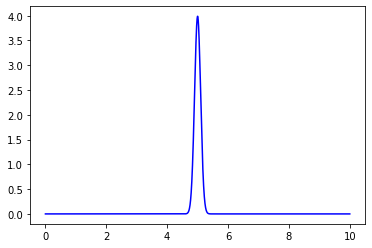

In [34]:
# kde = hashMap['N_O_1996-03-13']['l_extendedprice']

kde = KernelDensity(kernel='gaussian', bandwidth=.1).fit([[5]])
X_plot = np.linspace(0, 10, 10000)
logdens = kde.score_samples(X_plot[:,None])
plt.plot(X_plot, np.exp(logdens), color='b')

print(integrate.quad(lambda x: x * np.exp(kde.score_samples([[x]])), 45980, 45985))
print(integrate.quad(lambda x: x * np.exp(kde.score_samples([[x]])), 0, 100000))

In [42]:
min_date = lineitem_clean.select(f.min('l_shipdate')).first()[0]

In [51]:
(lineitem_clean.select(f.max('l_shipdate')).first()[0] - min_date).days

2505

In [194]:
np.array([[3, 2]])

array([[3, 2]])

# 2-D PDF's Normalization

In [141]:
to_select = ['l_quantity', 'l_extendedprice']
data_y = [random.choice([100, 101, 102]) for i in range(10)]
data_x = [random.choice([1, 2, 3]) for i in range(10)]
mean, std = np.mean(data_y), np.std(data_y)
transform = lambda x: (x - mean) / std
i_transform = lambda x: x * std + mean
X_original = pd.DataFrame({'x': data_x, 'y': data_y})
X = pd.DataFrame({'x': data_x, 'y': transform(data_y)})
X

,x,y
0,3,1.285714
1,2,1.285714
2,1,-1.571429
3,1,-1.571429
4,3,-0.142857
5,1,-0.142857
6,1,1.285714
7,3,-0.142857
8,2,-0.142857
9,1,-0.142857


In [189]:
X.values

array([[ 3.        ,  1.28571429],
       [ 2.        ,  1.28571429],
       [ 1.        , -1.57142857],
       [ 1.        , -1.57142857],
       [ 3.        , -0.14285714],
       [ 1.        , -0.14285714],
       [ 1.        ,  1.28571429],
       [ 3.        , -0.14285714],
       [ 2.        , -0.14285714],
       [ 1.        , -0.14285714]])

In [153]:
X_original[X_original.x == 3].mean()

x      3.000000
y    101.333333
dtype: float64

In [144]:
Counter(map(tuple, X.values))

Counter({(3.0, 1.2857142857142938): 1,
         (2.0, 1.2857142857142938): 1,
         (1.0, -1.5714285714285632): 2,
         (3.0, -0.14285714285713472): 2,
         (1.0, -0.14285714285713472): 2,
         (1.0, 1.2857142857142938): 1,
         (2.0, -0.14285714285713472): 1})

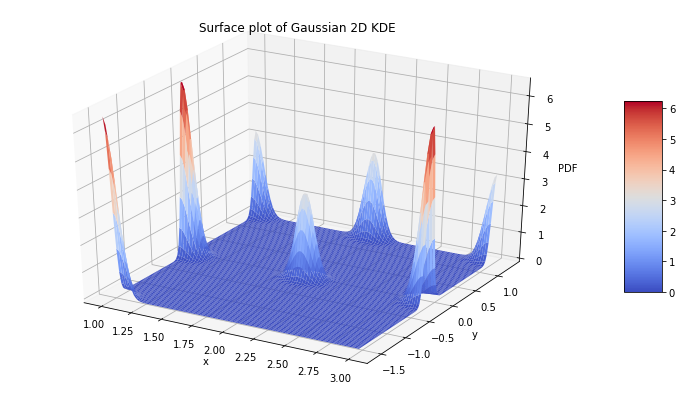

In [145]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=.07).fit(X.values)

# Compute the 3D values and coordinates
x = np.linspace(X[X.columns[0]].min(), X[X.columns[0]].max(), 100)
y = np.linspace(X[X.columns[1]].min(), X[X.columns[1]].max(), 100)
xx, yy = np.meshgrid(x, y)
z = kde.score_samples(list(zip(np.ravel(xx), np.ravel(yy))))
zz = np.exp(z).reshape(xx.shape)

# Plot the 3D prob density distribution
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF

In [154]:
# x is 1:3(date), while y is 101:103(quantity)
i1 = integrate.dblquad(lambda x, y: i_transform(y) * np.exp(kde.score_samples([[x,y]])), -2, 2, 2.5, 3.5)
i2 = integrate.dblquad(lambda x, y: np.exp(kde.score_samples([[x,y]])), -2, 2, 2.5, 3.5)
i1[0] / i2[0]

101.33333333333341

In [108]:
data.groupby('l_shipdate').mean().sort_index()#.loc[date(1995, 5, 23)]

,l_quantity
l_shipdate,
1995-05-23,16.0
1995-06-02,21.0
1995-06-05,19.5
1995-06-07,46.0
1995-06-08,43.5
...,...
1998-10-28,19.0
1998-10-30,6.0
1998-11-01,37.0


In [149]:
data = lineitem_clean.where(lineitem_clean['l_returnflag'] == 'N').select('l_shipdate', 'l_quantity').toPandas()
data = data.groupby('l_shipdate').mean().reset_index().sort_values('l_shipdate')
X, Y = data['l_shipdate'].apply(transform['date']).values.reshape(-1, 1), data['l_quantity'].apply(transform['quantity']).values.reshape(-1, 1)



# poly_features = PolynomialFeatures(degree=39)
# X_poly = poly_features.fit_transform(X)

KNN = KNeighborsRegressor(n_neighbors=1)
KNN.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

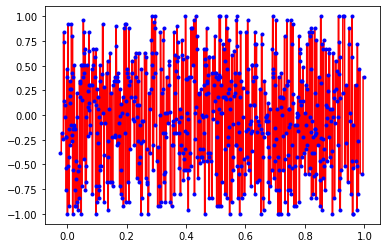

In [155]:
x_plot = np.linspace(min(X), max(X), 100000).reshape(-1, 1)
y_plot = KNN.predict(x_plot)
plt.plot(x_plot, y_plot, 'r-')
plt.plot(X, Y, 'b.')

In [151]:
calculate_size_of(KNN)

The size of the object in MB:  0.018804550170898438


19718

---
# Regression based

## Construction

In [147]:
def compute_regressions(s_values, bw='scott'):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    
    regression_bank = dict()
    
    # Training Data
    X_shipdate = []
    X_quantity = []
    X_price = []
    X_disc = []
    X_price_disc = []
    X_price_disc_tax = []
    count_order = 0
    
    # Fill in the training data
    for row in iterable_rows:
        X_shipdate.append(transform['date'](row['l_shipdate']))
        X_quantity.append(row['avg_qty'])
        X_price.append(row['avg_base_price'])
        X_disc.append(row['avg_disc'])
        X_price_disc.append(row['avg_disc_price'])
        X_price_disc_tax.append(row['avg_charge'])
        count_order += row['count_order']
    
    # Store the trained model into the KDE bank
    regression_bank['n'] = count_order
    regression_bank['date'] = gaussian_kde(X_shipdate, bw_method=bw)
    regression_bank['quantity'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_quantity).reshape(-1, 1))
    regression_bank['price'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_price).reshape(-1, 1))
    regression_bank['disc'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_disc).reshape(-1, 1))
    regression_bank['disc_price'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_price_disc).reshape(-1, 1))
    regression_bank['charge'] = KNeighborsRegressor(n_neighbors=1).fit(np.array(X_shipdate).reshape(-1, 1), np.array(X_price_disc_tax).reshape(-1, 1))
    
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, regression_bank]

In [150]:
def regression_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.groupby('l_returnflag', 'l_linestatus', 'l_shipdate')\
            .agg(f.avg('l_quantity').alias('avg_qty'), f.avg('l_extendedprice').alias('avg_base_price'), \
                 f.avg(col('l_extendedprice') * (1 - col('l_discount'))).alias('avg_disc_price'),\
                 f.avg(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('avg_charge'),\
                 f.avg('l_discount').alias('avg_disc'), f.count('*').alias('count_order') ).rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus']]), row)).groupByKey()\
        .map(compute_regressions)
    # (RDD) strat_kde: flag, status, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    # The last two items are: stratum_str(-2), kdes_bank(-1)
    
    strata_catalogue = strat_kde.map(lambda row: row[:3]).toDF(["l_returnflag", "l_linestatus", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

In [151]:
strata_catalogue, hashMap_reg = regression_based_method_construction(lineitem_clean)
strata_catalogue = strata_catalogue.cache()
strata_catalogue.show()

+------------+------------+-----------+
|l_returnflag|l_linestatus|stratum_str|
+------------+------------+-----------+
|           R|           F|        R_F|
|           N|           F|        N_F|
|           N|           O|        N_O|
|           A|           F|        A_F|
+------------+------------+-----------+



---
## Testing

In [157]:
def regression_based_cal_result(row, x_left, x_right):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    
    regression_bank = hashMap_reg[row['stratum_str']]
    
    x_left, x_right = transform['date'](left_date), transform['date'](right_date)
    i1 = integrate.quad(lambda x: regression_bank['quantity'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    i2 = integrate.quad(lambda x: regression_bank['date'].evaluate(x), x_left, x_right)
    avg_qty = i1[0] / i2[0]
    count_order = regression_bank['n'] * i2[0]
    sum_qty = avg_qty * count_order
    
    i1 = integrate.quad(lambda x: regression_bank['price'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    avg_price = i1[0] / i2[0]
    sum_base_price = avg_price * count_order
    
    i1 = integrate.quad(lambda x: regression_bank['disc'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    avg_disc = i1[0] / i2[0]
    
    i1 = integrate.quad(lambda x: regression_bank['disc_price'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    sum_disc_price = (i1[0] / i2[0]) * count_order
                      
    i1 = integrate.quad(lambda x: regression_bank['charge'].predict([[x]]) * regression_bank['date'].evaluate(x), x_left, x_right)
    sum_charge = (i1[0] / i2[0]) * count_order
                           
    return (row['l_returnflag'], row['l_linestatus'], sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order)


In [158]:
def regression_based_method_testing(strata_catalogue, left_date, right_date):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    Q1_reg_approx = strata_catalogue.rdd.map(lambda x: regression_based_cal_result(x, left_date, right_date))\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_reg_approx

In [159]:
Q1_reg_approx = regression_based_method_testing(strata_catalogue, LEFT_DATE, RIGHT_DATE).cache()
Q1_reg_approx.show()

+------------+------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+
|l_returnflag|l_linestatus|            sum_qty|      sum_base_price|      sum_disc_price|          sum_charge|           avg_qty|         avg_price|            avg_disc|      count_order|
+------------+------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+
|           A|           F|2.211007909811828E7|3.299506945835471E10|3.135900517113082...|3.261973755481355...|25.624631424350575| 38239.86743508044| 0.04980649204176925| 862844.765724416|
|           N|           F|  992355.1602135862|1.4877328263351738E9|1.4133065978085756E9| 1.469582251587495E9| 25.54061770251676| 38290.33886691651| 0.04988503660126164|          38854.0|
|           N|           O|7.432226464164348E7|1.11498183676

In [160]:
calculate_error(Q1_reg_approx, compute_exact_result(lineitem_clean, left_date, right_date))

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                             
A            F             3.892651        4.360658        4.326323   
N            F             0.094628        0.015335        0.015882   
             O             3.015982        2.990404        3.011878   
R            F             4.624680        4.464711        4.451695   

                           sum_charge   avg_qty  avg_price  avg_disc  \
l_returnflag l_linestatus                                              
A            F               4.307933  0.384644   0.104193  0.268655   
N            F               0.004556  0.094628   0.015335  0.416003   
             O               3.028391  0.072816   0.046461  0.093104   
R            F               4.500981  0.281150   0.113896  0.919728   

                           count_order  
l_returnflag l_linestatus               
A            F                4.260905  
N            F                0.000000  
             O                2.945311  
R            F                4.355776

In [161]:
calculate_error(Q1_reg_approx, compute_exact_result(lineitem_clean, left_date, right_date)).mean().mean()

1.9212279264971754

In [ ]:
1.8894579783263232